New AnalogNet2 architecture reaches 97.3% testing acuracy.

In [0]:
EPOCHS = 50
BATCH_SIZE = 100
LR = 0.001

#0. Import Data / Utils functions

In [0]:
%matplotlib inline
import tensorflow as tf
import tensorflow.contrib.slim as slim
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle

In [0]:
mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()

# Simulate an input binarization
x_train = np.minimum(x_train, 100) // 100 * 120
x_test = np.minimum(x_test, 100) // 100 * 120

# 1. Network definition and training

## 1.1 Network definition

In [0]:
# Sigmoids, whose steepness and bias can be adjusted
# A very steep sigmoid (high bin_rate) simulates a binarization
MAX_BIN_RATE = 50
def binarize_tensor_differentiable(input, thresh, bin_rate):
  out1 = tf.nn.sigmoid(bin_rate*(input[...,:1] - thresh[0]))
  out2 = tf.nn.sigmoid(bin_rate*(input[...,1:2] - thresh[1]))
  out3 = tf.nn.sigmoid(bin_rate*(input[...,2:3] - thresh[2]))
  return tf.concat([out1, out2, out3], axis=-1)

In [0]:
def custom_pooling(conv_bin):
  sum1 = tf.reduce_sum(conv_bin[:,5:14,0:9,:], axis=[1,2])
  sum2 = tf.reduce_sum(conv_bin[:,14:23,0:9,:], axis=[1,2])
  sum3 = tf.reduce_sum(conv_bin[:,0:9,5:14,:], axis=[1,2])
  sum4 = tf.reduce_sum(conv_bin[:,5:14,5:14,:], axis=[1,2])
  sum5 = tf.reduce_sum(conv_bin[:,14:23,5:14,:], axis=[1,2])
  sum6 = tf.reduce_sum(conv_bin[:,19:28,5:14,:], axis=[1,2])
  sum7 = tf.reduce_sum(conv_bin[:,0:9,14:23,:], axis=[1,2])
  sum8 = tf.reduce_sum(conv_bin[:,5:14,14:23,:], axis=[1,2])
  sum9 = tf.reduce_sum(conv_bin[:,14:23,14:23,:], axis=[1,2])
  sum10 = tf.reduce_sum(conv_bin[:,19:28,14:23,:], axis=[1,2])
  sum11 = tf.reduce_sum(conv_bin[:,5:14,19:28,:], axis=[1,2])
  sum12 = tf.reduce_sum(conv_bin[:,14:23,19:28,:], axis=[1,2])
  
  pool = tf.concat([sum1, sum2, sum3, sum4, sum5, sum6, 
                       sum7, sum8, sum9, sum10, sum11, sum12], axis=1)
  
  return pool

In [0]:
def network(input, thresh, bin_rate_ph):
  # First Convolution
  conv = slim.conv2d(input, 3, [3, 3], rate=1,
                     activation_fn=None, biases_initializer=None,
                     padding='SAME', scope='conv1')
  
  
  # Sigmoid as output binarisation
  # Thresholds act as bias here
  conv = binarize_tensor_differentiable(conv, thresh, bin_rate_ph)
  
  # Sum pooling
  pool = custom_pooling(conv)
  
  # Flatten + dense
  flat = tf.layers.flatten(pool)
  dense = tf.layers.dense(flat, 50, name='dense1', activation=tf.nn.relu)
  out = tf.layers.dense(dense, 10, name='dense2')
  
  return out

In [8]:
## Define the graph
tf.reset_default_graph()

in_image_ph = tf.placeholder(tf.float32, [BATCH_SIZE,28,28,1])
bin_rate_ph = tf.placeholder(tf.float32, ())
gt_label_ph = tf.placeholder(tf.uint8)
thresh = tf.Variable(tf.random.normal([3]), name='out_thresholds')

out_label_op = network(in_image_ph, thresh, bin_rate_ph)

pred_op = tf.dtypes.cast(
            tf.keras.backend.argmax(out_label_op),
            tf.uint8)

loss_op = tf.reduce_mean(
          tf.keras.backend.sparse_categorical_crossentropy(gt_label_ph,
                                                           out_label_op,
                                                           from_logits=True))

acc_op = tf.contrib.metrics.accuracy(gt_label_ph, pred_op)

W0903 10:25:14.266215 139742096562048 deprecation.py:323] From <ipython-input-6-bf2c30eb0215>:16: flatten (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.flatten instead.
W0903 10:25:14.483978 139742096562048 deprecation.py:323] From <ipython-input-6-bf2c30eb0215>:17: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.
W0903 10:25:14.486419 139742096562048 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
#[n.name for n in tf.get_default_graph().as_graph_def().node]

In [0]:
with tf.variable_scope('conv1', reuse=True) as scope_conv:
  w1 = tf.get_variable('weights')

In [0]:
# Define regularizers
ROUNDING_STEP_CONV = 0.25
ROUNDING_STEP_BIAS = 1.
REG_CONSTANT = 25.

In [0]:
def customRegularizerConv(x):
  return tf.math.cos(2/ROUNDING_STEP_CONV*np.pi*(x-ROUNDING_STEP_CONV/2))+1.

def customRegularizerBias(x):
  return tf.math.cos(2/ROUNDING_STEP_BIAS*np.pi*(x-ROUNDING_STEP_BIAS/2))+1.

In [0]:
NUM_PARAM_REG = 30. + 27. + 27. + 27. + 3.
reg_losses = 27./NUM_PARAM_REG *tf.reduce_mean(customRegularizerConv(w1))
reg_losses += 3./NUM_PARAM_REG*tf.reduce_mean(customRegularizerBias(thresh))

reg_factor_ph = tf.placeholder(tf.float32)
loss_with_reg_op = loss_op + reg_factor_ph * reg_losses

lr_ph = tf.placeholder(tf.float32)
opt = tf.train.AdamOptimizer(learning_rate=lr_ph, name='Adam_reg')
opt_op = opt.minimize(loss_with_reg_op)
sess.run(tf.variables_initializer(opt.variables()))

## 1.2 Training

Evolving params:
- lr_ph : learning rate
- reg_factor_ph : regularization factor -> this time, set directly to final value in the second learning stage
- bin_rate_ph : binarization rate -> this time, set directly to final value in the third learning stage

In [0]:
INPUT_SCALING = 1. # So that intermediate values stay in the -127, +127 range

In [0]:
def test_accuracy_bin_rate(bin_rate_feed):
  accs = np.zeros(x_test.shape[0] // BATCH_SIZE)
  for i in range(x_test.shape[0] // BATCH_SIZE):
    start = i * BATCH_SIZE
    stop = start + BATCH_SIZE
    
    xs = np.expand_dims(x_test[start:stop],-1) * INPUT_SCALING
    ys = y_test[start:stop]
    
    current_acc = sess.run(acc_op,
                       feed_dict={in_image_ph: xs,
                                  gt_label_ph: ys,
                                  bin_rate_ph: bin_rate_feed})
    accs[i] = current_acc
  
  print('Testing Acc.: {}'.format(
        accs.mean()))

In [0]:
# Initial version, reg then bin
for epoch in range(EPOCHS*12):
  if epoch < EPOCHS * 4:
    lr_feed = LR
    reg_factor_feed = 0.
    bin_rate_feed = 1.
  elif epoch < EPOCHS * 8:
    lr_feed = LR / 2.
    #reg_factor_feed = adaptative_factor(epoch - EPOCHS * 4, EPOCHS * 4)
    reg_factor_feed = REG_CONSTANT
    bin_rate_feed = 1.
  else:
    lr_feed = LR / 4.
    reg_factor_feed = REG_CONSTANT
    #bin_rate_feed = adaptative_factor(epoch - EPOCHS * 8, EPOCHS * 4)
    bin_rate_feed = MAX_BIN_RATE + 1
    
# Bin then reg
for epoch in range(EPOCHS*12):
  if epoch < EPOCHS * 4:
    lr_feed = LR
    reg_factor_feed = 0.
    bin_rate_feed = 1.
  elif epoch < EPOCHS * 8:
    lr_feed = LR / 2.
    reg_factor_feed = 0.
    bin_rate_feed = MAX_BIN_RATE + 1
  else:
    lr_feed = LR / 4.
    reg_factor_feed = REG_CONSTANT
    bin_rate_feed = MAX_BIN_RATE + 1

In [16]:
# Initial version, reg then bin
for epoch in range(EPOCHS*12):
  if epoch < EPOCHS * 4:
    lr_feed = LR
    reg_factor_feed = 0.
    bin_rate_feed = 1.
  elif epoch < EPOCHS * 8:
    lr_feed = LR / 2.
    #reg_factor_feed = adaptative_factor(epoch - EPOCHS * 4, EPOCHS * 4)
    reg_factor_feed = REG_CONSTANT
    bin_rate_feed = 1.
  else:
    lr_feed = LR / 4.
    reg_factor_feed = REG_CONSTANT
    #bin_rate_feed = adaptative_factor(epoch - EPOCHS * 8, EPOCHS * 4)
    bin_rate_feed = MAX_BIN_RATE + 1
    
  random_perm = np.random.permutation(x_train.shape[0])
  losses = np.zeros(x_train.shape[0] // BATCH_SIZE)
  for i in range(x_train.shape[0] // BATCH_SIZE):
    start = i * BATCH_SIZE
    stop = start + BATCH_SIZE
    selected = random_perm[start:stop]
    
    xs = np.expand_dims(x_train[selected],-1) * INPUT_SCALING
    ys = y_train[selected]
    
    _, current_loss = sess.run([opt_op, loss_op],
                       feed_dict={in_image_ph: xs,
                                  gt_label_ph: ys,
                                  lr_ph: lr_feed,
                                  reg_factor_ph: reg_factor_feed,
                                  bin_rate_ph: bin_rate_feed})

    losses[i] = current_loss
  
  print('Epoch {} completed, average training loss is {}'.format(
          epoch+1, losses.mean()))
  test_accuracy_bin_rate(bin_rate_feed)

Epoch 1 completed, average training loss is 2.8012129905819894
Testing Acc.: 0.6512999993562698
Epoch 2 completed, average training loss is 0.8566882961988449
Testing Acc.: 0.7731000012159348
Epoch 3 completed, average training loss is 0.647887048125267
Testing Acc.: 0.8019999974966049
Epoch 4 completed, average training loss is 0.5606415886431932
Testing Acc.: 0.8558999979496003
Epoch 5 completed, average training loss is 0.48402199673155943
Testing Acc.: 0.8655999982357026
Epoch 6 completed, average training loss is 0.4552480389922857
Testing Acc.: 0.8712000000476837
Epoch 7 completed, average training loss is 0.42331065754095715
Testing Acc.: 0.881800000667572
Epoch 8 completed, average training loss is 0.39558583254615465
Testing Acc.: 0.8994000029563903
Epoch 9 completed, average training loss is 0.3749013516306877
Testing Acc.: 0.8851999986171722
Epoch 10 completed, average training loss is 0.3537087134023507
Testing Acc.: 0.9027000015974045
Epoch 11 completed, average training l

In [17]:
# ^^^^ Above reads:
### Epoch 600 completed, average training loss is 0.07214291953093682
### Testing Acc.: 0.9724000024795533


# Save model, for not having to fully retrain it each time.
saver = tf.train.Saver()
saver.save(sess, 'AnalogNet2/model.ckpt')


'AnalogNet2/model.ckpt'

In [18]:
test_accuracy_bin_rate(MAX_BIN_RATE + 1)

Testing Acc.: 0.9724000024795533


In [19]:
!zip -r AnalogNet2.zip AnalogNet2

  adding: AnalogNet2/ (stored 0%)
  adding: AnalogNet2/model.ckpt.data-00000-of-00001 (deflated 25%)
  adding: AnalogNet2/model.ckpt.index (deflated 40%)
  adding: AnalogNet2/checkpoint (deflated 42%)
  adding: AnalogNet2/model.ckpt.meta (deflated 88%)


## 1.3 Weights rounding: 97.46%

In [0]:
!unzip AnalogNet2.zip

Archive:  unquantised.zip
replace unquantised/model.ckpt.data-00000-of-00001? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [20]:
# Sigmoids, whose steepness and bias can be adjusted
# A very steep sigmoid (high bin_rate) simulates a binarization
MAX_BIN_RATE = 50
def binarize_tensor_differentiable(input, thresh, bin_rate):
  out1 = tf.nn.sigmoid(bin_rate*(input[...,:1] - thresh[0]))
  out2 = tf.nn.sigmoid(bin_rate*(input[...,1:2] - thresh[1]))
  out3 = tf.nn.sigmoid(bin_rate*(input[...,2:3] - thresh[2]))
  return tf.concat([out1, out2, out3], axis=-1)

def custom_pooling(conv_bin):
  sum1 = tf.reduce_sum(conv_bin[:,5:14,0:9,:], axis=[1,2])
  sum2 = tf.reduce_sum(conv_bin[:,14:23,0:9,:], axis=[1,2])
  sum3 = tf.reduce_sum(conv_bin[:,0:9,5:14,:], axis=[1,2])
  sum4 = tf.reduce_sum(conv_bin[:,5:14,5:14,:], axis=[1,2])
  sum5 = tf.reduce_sum(conv_bin[:,14:23,5:14,:], axis=[1,2])
  sum6 = tf.reduce_sum(conv_bin[:,19:28,5:14,:], axis=[1,2])
  sum7 = tf.reduce_sum(conv_bin[:,0:9,14:23,:], axis=[1,2])
  sum8 = tf.reduce_sum(conv_bin[:,5:14,14:23,:], axis=[1,2])
  sum9 = tf.reduce_sum(conv_bin[:,14:23,14:23,:], axis=[1,2])
  sum10 = tf.reduce_sum(conv_bin[:,19:28,14:23,:], axis=[1,2])
  sum11 = tf.reduce_sum(conv_bin[:,5:14,19:28,:], axis=[1,2])
  sum12 = tf.reduce_sum(conv_bin[:,14:23,19:28,:], axis=[1,2])
  
  pool = tf.concat([sum1, sum2, sum3, sum4, sum5, sum6, 
                       sum7, sum8, sum9, sum10, sum11, sum12], axis=1)
  
  return pool

def network(input, thresh, bin_rate_ph):
  # First Convolution
  conv = slim.conv2d(input, 3, [3, 3], rate=1,
                     activation_fn=None, biases_initializer=None,
                     padding='SAME', scope='conv1')
  
  
  # Sigmoid as output binarisation
  # Thresholds act as bias here
  conv = binarize_tensor_differentiable(conv, thresh, bin_rate_ph)
  
  # Sum pooling
  pool = custom_pooling(conv)
  
  # Flatten + dense
  flat = tf.layers.flatten(pool)
  dense = tf.layers.dense(flat, 50, name='dense1', activation=tf.nn.relu)
  out = tf.layers.dense(dense, 10, name='dense2')
  
  return out

## Define the graph
tf.reset_default_graph()

in_image_ph = tf.placeholder(tf.float32, [BATCH_SIZE,28,28,1])
bin_rate_ph = tf.placeholder(tf.float32, ())
gt_label_ph = tf.placeholder(tf.uint8)
thresh = tf.Variable(tf.random.normal([3]), name='out_thresholds')

out_label_op = network(in_image_ph, thresh, bin_rate_ph)

pred_op = tf.dtypes.cast(
            tf.keras.backend.argmax(out_label_op),
            tf.uint8)

loss_op = tf.reduce_mean(
          tf.keras.backend.sparse_categorical_crossentropy(gt_label_ph,
                                                           out_label_op,
                                                           from_logits=True))

acc_op = tf.contrib.metrics.accuracy(gt_label_ph, pred_op)

saver = tf.train.Saver()
sess = tf.Session()
sess.run(tf.global_variables_initializer())
ckpt = tf.train.get_checkpoint_state('AnalogNet2')
saver.restore(sess, ckpt.model_checkpoint_path)
test_accuracy_bin_rate(MAX_BIN_RATE)

W0903 11:05:21.840816 139742096562048 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


Testing Acc.: 0.9724000024795533


In [0]:
with tf.variable_scope('conv1', reuse=True) as scope_conv:
  w1 = tf.get_variable('weights')

In [0]:
# Define regularizers
ROUNDING_STEP_CONV = 0.25
ROUNDING_STEP_BIAS = 1.
REG_CONSTANT = 4.

Testing Acc.: 0.9724000024795533


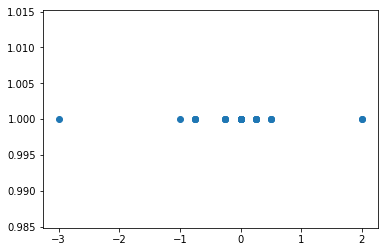

In [23]:
# Rounding operation
rounding_weights1_op = tf.assign(w1, 
                          tf.round(w1/ROUNDING_STEP_CONV)*ROUNDING_STEP_CONV)
rounding_thresh_op = tf.assign(thresh,
                          tf.round(thresh/ROUNDING_STEP_BIAS)*ROUNDING_STEP_BIAS)
_ = sess.run([rounding_weights1_op, rounding_thresh_op])


# Show final distribution of weights
w1_values, thresh_values = sess.run([w1, thresh])

kernel_values = (list(w1_values.flatten()) + list(thresh_values.flatten()))
fig = plt.figure()
plt.scatter(kernel_values, [1]*len(kernel_values))

test_accuracy_bin_rate(MAX_BIN_RATE)

## 1.4 Retrain FC: 

In [0]:
LR = 0.001/4

In [0]:
with tf.variable_scope('dense1', reuse=True) as scope_conv:
  fc1_k = tf.get_variable('kernel')
  fc1_b = tf.get_variable('bias')

with tf.variable_scope('dense2', reuse=True) as scope_conv:
  fc2_k = tf.get_variable('kernel')
  fc2_b = tf.get_variable('bias')

opt_fc = tf.train.AdamOptimizer(learning_rate=LR, name='Adam_reg')
opt_fc_op = opt_fc.minimize(loss_op, var_list=[fc1_k, fc1_b,
                                               fc2_k, fc2_b])

sess.run(tf.variables_initializer(opt_fc.variables()))

In [0]:
def test_accuracy_bin_rate(bin_rate_feed):
  accs = np.zeros(x_test.shape[0] // BATCH_SIZE)
  for i in range(x_test.shape[0] // BATCH_SIZE):
    start = i * BATCH_SIZE
    stop = start + BATCH_SIZE
    
    xs = np.expand_dims(x_test[start:stop],-1) * INPUT_SCALING
    ys = y_test[start:stop]
    
    current_acc = sess.run(acc_op,
                       feed_dict={in_image_ph: xs,
                                  gt_label_ph: ys,
                                  bin_rate_ph: bin_rate_feed})
    accs[i] = current_acc
  
  print('Testing Acc.: {}'.format(
        accs.mean()))

In [27]:
bin_rate_feed = MAX_BIN_RATE + 1

for epoch in range(EPOCHS*2):

  random_perm = np.random.permutation(x_train.shape[0])
  losses = np.zeros(x_train.shape[0] // BATCH_SIZE)
  for i in range(x_train.shape[0] // BATCH_SIZE):
    start = i * BATCH_SIZE
    stop = start + BATCH_SIZE
    selected = random_perm[start:stop]

    xs = np.expand_dims(x_train[selected],-1) * INPUT_SCALING
    ys = y_train[selected]

    _, current_loss = sess.run([opt_fc_op, loss_op],
                       feed_dict={in_image_ph: xs,
                                  gt_label_ph: ys,
                                  bin_rate_ph: bin_rate_feed})

    losses[i] = current_loss

  print('Epoch {} completed, average training loss is {}'.format(
          epoch+1, losses.mean()))
  test_accuracy_bin_rate(bin_rate_feed)

test_accuracy_bin_rate(MAX_BIN_RATE + 1)


Epoch 1 completed, average training loss is 0.07271423984629412
Testing Acc.: 0.9721000015735626
Epoch 2 completed, average training loss is 0.07231792200123892
Testing Acc.: 0.9722000020742416
Epoch 3 completed, average training loss is 0.0725571571670783
Testing Acc.: 0.9729000025987625
Epoch 4 completed, average training loss is 0.07230805087834596
Testing Acc.: 0.9734000015258789
Epoch 5 completed, average training loss is 0.07237334372087692
Testing Acc.: 0.9728000009059906
Epoch 6 completed, average training loss is 0.07222244912525638
Testing Acc.: 0.9726000016927719
Epoch 7 completed, average training loss is 0.07303836764379715
Testing Acc.: 0.9732000023126602
Epoch 8 completed, average training loss is 0.07253301594406367
Testing Acc.: 0.9710000020265579
Epoch 9 completed, average training loss is 0.07235471939202398
Testing Acc.: 0.9729000008106232
Epoch 10 completed, average training loss is 0.07223454114049672
Testing Acc.: 0.9727000021934509
Epoch 11 completed, average tr

In [28]:
test_accuracy_bin_rate(MAX_BIN_RATE)
test_accuracy_bin_rate(5000)

Testing Acc.: 0.9734000039100646
Testing Acc.: 0.9734000039100646


In [0]:
# Get final distribution of weights
w1_values, thresh_values = sess.run([w1, thresh])

with open('NP_KERNELS_WEIGHTS.pck', 'wb') as f:
  pickle.dump((w1_values, thresh_values), f)